<a href="https://colab.research.google.com/github/RAVIPATISRIVIDYA/devtraining-needit-madrid/blob/master/Privacy_attack_MIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Import statements.
import numpy as np
from typing import Tuple, Text
from scipy import special

import tensorflow as tf
import tensorflow_datasets as tfds

# Set verbosity.
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter(action="ignore", category=ConvergenceWarning)
simplefilter(action="ignore", category=FutureWarning)

In [ ]:
#@markdown Train a simple model on CIFAR100 with Keras.
dataset = 'cifar100'
num_classes = 100
num_conv = 3
activation = 'relu'
lr = 0.05
momentum = 0.7
batch_size = 70
epochs = 100  # Privacy risks are especially visible with lots of epochs.


def small_cnn(input_shape: Tuple[int],
              num_classes: int,
              num_conv: int,
              activation: Text = 'relu') -> tf.keras.models.Sequential:
  """Setup a small CNN for image classification.

  Args:
    input_shape: Integer tuple for the shape of the images.
    num_classes: Number of prediction classes.
    num_conv: Number of convolutional layers.
    activation: The activation function to use for conv and dense layers.

  Returns:
    The Keras model.
  """
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input(shape=input_shape))

  # Conv layers
  for _ in range(num_conv):
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation=activation))
    model.add(tf.keras.layers.MaxPooling2D())

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(64, activation=activation))
  model.add(tf.keras.layers.Dense(num_classes))
  return model

In [ ]:
print('Loading the dataset.')
train_ds= tfds.as_numpy(tfds.load(dataset, split=tfds.Split.TRAIN, batch_size=-1))
test_ds = tfds.as_numpy(tfds.load(dataset, split=tfds.Split.TEST, batch_size=-1))

Loading the dataset.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar100/3.0.2.incompleteJ0WVGZ/cifar100-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar100/3.0.2.incompleteJ0WVGZ/cifar100-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar100 downloaded and prepared to /root/tensorflow_datasets/cifar100/3.0.2. Subsequent calls will reuse this data.


In [ ]:
# Run this only once. 
!pip3 install git+https://github.com/tensorflow/privacy
from tensorflow_privacy.privacy.membership_inference_attack import membership_inference_attack as mia

  Cloning https://github.com/tensorflow/privacy to /tmp/pip-req-build-vt6vc42h
  Running command git clone -q https://github.com/tensorflow/privacy /tmp/pip-req-build-vt6vc42h
     |████████████████████████████████| 4.0 MB 3.4 MB/s 
  Created wheel for tensorflow-privacy: filename=tensorflow_privacy-0.7.3-py3-none-any.whl size=266056 sha256=71d8034c5dbc6d51e6ee02b833336721b0570e31576fe0f7aa7b58fa235d4add
  Stored in directory: /tmp/pip-ephem-wheel-cache-vmi4xnxq/wheels/a8/64/6f/9c838f8bb45e29d4c0b7b872d965250bed1d9ac89f66953b02
Successfully built tensorflow-privacy
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


/usr/local/lib/python3.7/dist-packages/tensorflow_privacy/privacy/membership_inference_attack/__init__.py:19: UserWarning: 
Membership inference attack sources were moved. Please replace
import tensorflow_privacy.privacy.membership_inference_attack

with
import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack
  "\nMembership inference attack sources were moved. Please replace"


In [ ]:
x_train = train_ds['image'].astype('float32') / 255.
y_train_indices = train_ds['label'][:, np.newaxis]
x_test = test_ds['image'].astype('float32') / 255.
y_test_indices = test_ds['label'][:, np.newaxis]

In [ ]:
num_classes

100

In [ ]:
# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train_indices, num_classes)
y_test = tf.keras.utils.to_categorical(y_test_indices, num_classes)

In [ ]:
input_shape = x_train.shape[1:]

model = small_cnn(
    input_shape, num_classes, num_conv=num_conv, activation=activation)

print('learning rate %f', lr)

optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=momentum)

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model.summary()
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=1,
    validation_data=(x_test, y_test),
    shuffle=True)
print('Finished training.')


learning rate %f 0.05
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 32)          9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (Non

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


715/715 [==============================] - 17s 11ms/step - loss: 4.3065 - accuracy: 0.0448 - val_loss: 4.0496 - val_accuracy: 0.0770
Finished training.


In [ ]:
print('Predict on train...')
logits_train = model.predict(x_train, batch_size=batch_size)
print('Predict on test...')
logits_test = model.predict(x_test, batch_size=batch_size)

print('Apply softmax to get probabilities from logits...')
prob_train = special.softmax(logits_train, axis=1)
prob_test = special.softmax(logits_test, axis=1)

print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

loss_train = cce(constant(y_train), constant(prob_train), from_logits=False).numpy()
loss_test = cce(constant(y_test), constant(prob_test), from_logits=False).numpy()

Predict on train...
Predict on test...
Apply softmax to get probabilities from logits...
Compute losses...


Best-performing attacks over all slices
  THRESHOLD_ATTACK (with 500 training and 100 test examples) achieved an AUC of 0.58 on slice CLASS=22
  THRESHOLD_ATTACK (with 500 training and 100 test examples) achieved an advantage of 0.16 on slice CLASS=22

Best-performing attacks over slice: "Entire dataset"
  THRESHOLD_ATTACK (with 50000 training and 10000 test examples) achieved an AUC of 0.50
  THRESHOLD_ATTACK (with 50000 training and 10000 test examples) achieved an advantage of 0.01

Best-performing attacks over slice: "CLASS=0"
  THRESHOLD_ATTACK (with 500 training and 100 test examples) achieved an AUC of 0.43
  THRESHOLD_ATTACK (with 500 training and 100 test examples) achieved an advantage of 0.16

Best-performing attacks over slice: "CLASS=1"
  THRESHOLD_ATTACK (with 500 training and 100 test examples) achieved an AUC of 0.48
  THRESHOLD_ATTACK (with 500 training and 100 test examples) achieved an advantage of 0.08

Best-performing attacks over slice: "CLASS=2"
  THRESHOLD_ATTAC

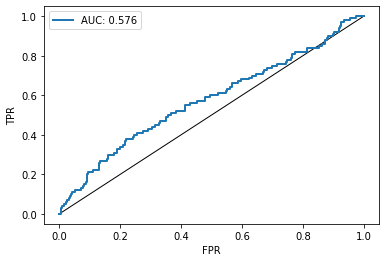

In [ ]:
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackType

import tensorflow_privacy.privacy.membership_inference_attack.plotting as plotting

labels_train = np.argmax(y_train, axis=1)
labels_test = np.argmax(y_test, axis=1)

input = AttackInputData(
  logits_train = logits_train,
  logits_test = logits_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = labels_train,
  labels_test = labels_test
)

# Run several attacks for different data slices
attacks_result = mia.run_attacks(input,
                                 SlicingSpec(
                                     entire_dataset = True,
                                     by_class = True,
                                     by_classification_correctness = True
                                 ),
                                 attack_types = [
                                     AttackType.THRESHOLD_ATTACK])

# Plot the ROC curve of the best classifier
fig = plotting.plot_roc_curve(
    attacks_result.get_result_with_max_auc().roc_curve)

# Print a user-friendly summary of the attacks
print(attacks_result.summary(by_slices = True))